# Spaceship Titanic Dataset with TensorFlow Decision Forests

# Import the library

In [1]:
!pip install -Uq fastbook

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import fastbook
fastbook.setup_book()

In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from fastai import *
from fastai.tabular import *
from fastai.metrics import *
from fastai.tabular.all import *

# Load the Dataset

In [4]:
#train_df = pd.read_csv("../input/spaceship-titanic/train.csv")
df = pd.read_csv("../input/spaceship-titanic/train.csv")

In [5]:
#df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
#df = train_df
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


There are 12 feature columns. Using these features your model has to predict whether the passenger is rescued or not indicated by the column `Transported`.

# Prepare the dataset

In [6]:
#Get the group from the passenger ID
df[["passenger_id", "group_id"]] = df["PassengerId"].str.split("_", expand=True)
#fill blank values
df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
#change dtypes
df['VIP'] = df['VIP'].astype(int)
df['CryoSleep'] = df['CryoSleep'].astype(int)
#split cabin/number/side
df[["Deck", "Cabin_num", "Side"]] = df["Cabin"].str.split("/", expand=True)
#change category dtypes
df['HomePlanet'] = df['HomePlanet'].astype('category')
df['Destination'] = df['Destination'].astype('category')
df['Side'] = df['Side'].astype('category')
df['Deck'] = df['Deck'].astype('category')
df['CryoSleep'] = df['CryoSleep'].astype('category')
df['VIP'] = df['VIP'].astype('category')
df['group_id'] = df['group_id'].astype('category')
#convert labels to numbers
df['HomePlanet'] = df['HomePlanet'].map( {'Earth': 0, 'Europa': 1, 'Mars': 2} )
df['Destination'] = df['Destination'].map( {'55 Cancri e': 0, 'PSO J318.5-22': 1, 'TRAPPIST-1e': 2} )
df['Deck'] = df['Deck'].map( {'A' : 0,'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4, 'F' : 5, 'G' : 6, 'T' : 7})
df['Side'] = df['Side'].map( {'P' : 0,'S' : 1})
#normalise numeric values
age_avg = df['Age'].mean()
age_std = df['Age'].std()
df.fillna({'Age': np.random.randint(age_avg - age_std, age_avg + age_std)}, inplace=True)
df['age_value']=df['Age']/50
df['RoomService'].fillna(np.mean(df['RoomService']), inplace=True)
df['RoomService_value']=df['RoomService']/50
df['FoodCourt'].fillna(np.mean(df['FoodCourt']), inplace=True)
df['FoodCourt_value']=df['FoodCourt']/50
df['ShoppingMall'].fillna(np.mean(df['ShoppingMall']), inplace=True)
df['ShoppingMall_value']=df['ShoppingMall']/50
df['Spa'].fillna(np.mean(df['Spa']), inplace=True)
df['Spa_value']=df['Spa']/50
df['VRDeck'].fillna(np.mean(df['VRDeck']), inplace=True)
df['VRDeck_value']=df['VRDeck']/50
#scale the normalized values
scale_cols = ["age_value", "RoomService_value", "FoodCourt_value", "ShoppingMall_value", "Spa_value", "VRDeck_value"]  
scale = MinMaxScaler()
df[scale_cols] = scale.fit_transform(df[scale_cols])
#drop the unwanted columns
delete_df_columns = ['PassengerId', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService', 'Age', 'VRDeck', 'Name', 'passenger_id', 'Cabin', 'Cabin_num']
df.drop(delete_df_columns, axis=1, inplace=True)
#one-hot encode categories
df = pd.get_dummies(df, columns=['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'group_id', 'Deck', 'Side'], dtype=int)
#view results
df.head(5)

/tmp/ipykernel_34/3591166566.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RoomService'].fillna(np.mean(df['RoomService']), inplace=True)
/tmp/ipykernel_34/3591166566.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

,PassengerId,Transported,age_value,RoomService_value,FoodCourt_value,ShoppingMall_value,Spa_value,VRDeck_value,HomePlanet_0,HomePlanet_1,HomePlanet_2,CryoSleep_0,CryoSleep_1,Destination_0,Destination_1,Destination_2,VIP_0,VIP_1,group_id_01,group_id_02,group_id_03,group_id_04,group_id_05,group_id_06,group_id_07,group_id_08,Deck_0,Deck_1,Deck_2,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Side_0,Side_1
0,0001_01,False,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,0002_01,True,0.303797,0.007608,0.000302,0.001064,0.024500,0.001823,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0003_01,False,0.734177,0.003001,0.119948,0.000000,0.299670,0.002030,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,0003_02,False,0.417722,0.000000,0.043035,0.015793,0.148563,0.007997,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,0004_01,True,0.202532,0.021149,0.002348,0.006428,0.025214,0.000083,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [7]:
#df = df[df['HomePlanet'].notna()]
#df = df[df['Destination'].notna()]
#df = df[df['Age'].notna()]
#df = df[df['RoomService'].notna()]

Show a heatmap of the inputs

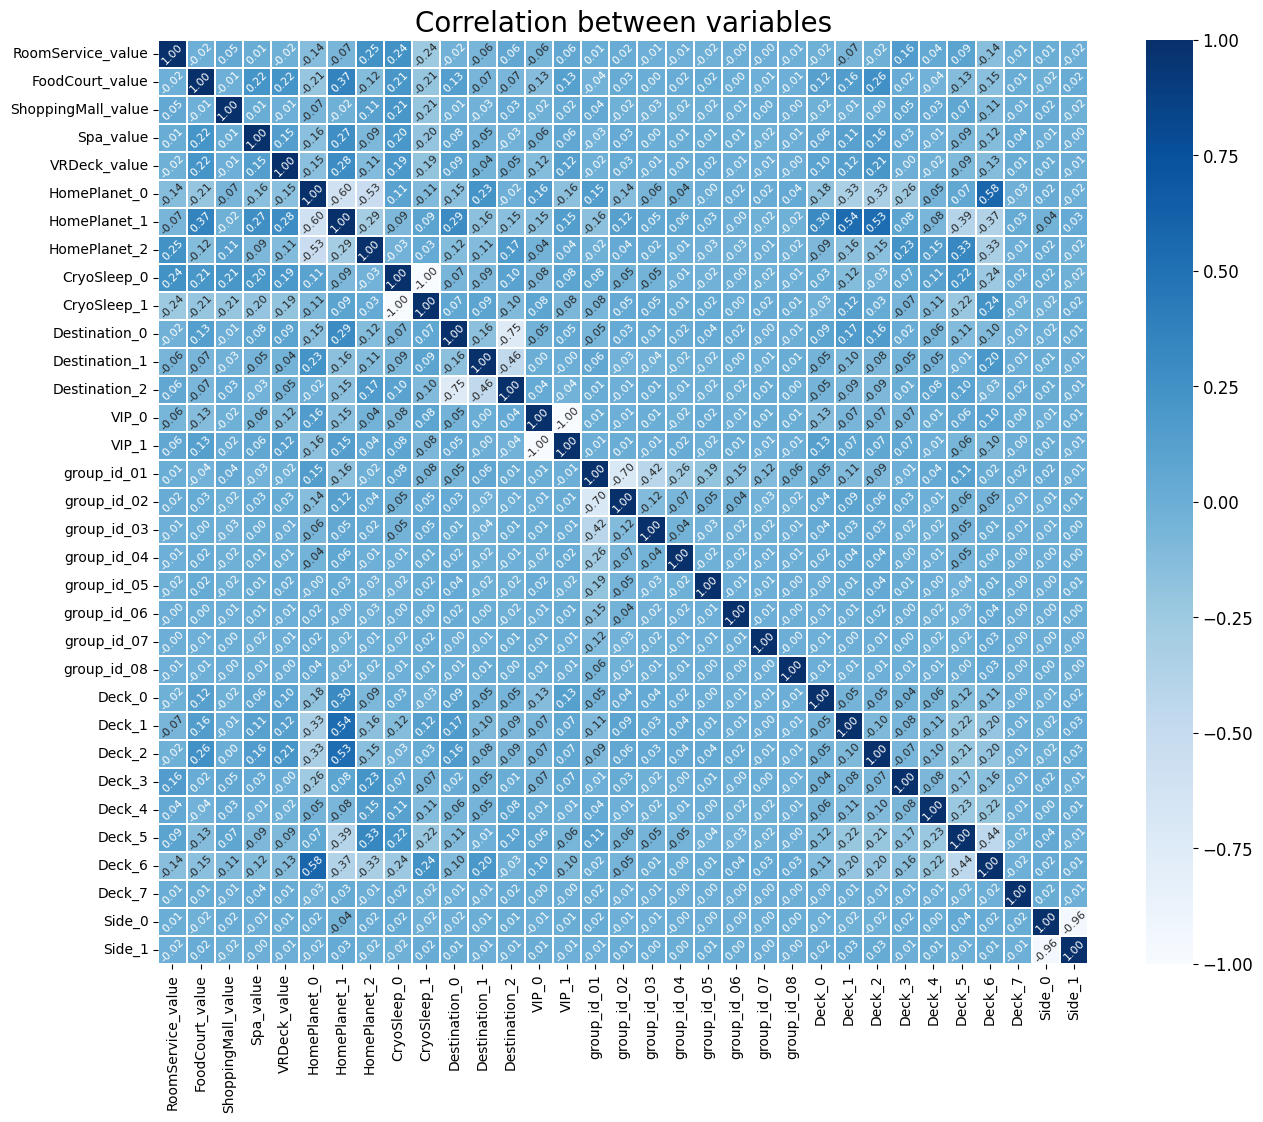

In [8]:
plt.figure(figsize=(15,12))
sns.heatmap(df.iloc[:,3:].corr(), linewidths=0.05, annot=True,
            annot_kws={'size': 8, 'rotation': 45}, fmt='.2f', cmap="Blues")
plt.xticks(fontsize=10), plt.yticks(fontsize=10)
plt.title("Correlation between variables", fontsize=20)
plt.show()

Show the correlation of inputs

# Test some models

In [9]:
# Create train-validation splits
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [13]:
train = df.iloc[:8693, :].drop([], axis=1)
test = df.iloc[8693:, :].drop([], axis=1)
train.dropna(inplace=True)

In [15]:
y = train["Transported"]
X = train.drop(["Transported"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("X_train",len(X_train))
print("X_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))
print("test",len(df))

X_train 6519
X_test 2174
y_train 6519
y_test 2174
test 8693


In [17]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': xgb.XGBClassifier(enable_categorical=True),
    'Gradient Boost' : GradientBoostingClassifier()
}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f'{model_name}: Accuracy = {accuracy:.4f}')

Logistic Regression: Accuracy = 0.5023
Decision Tree: Accuracy = 0.7438
Random Forest: Accuracy = 0.7939
SVM: Accuracy = 0.5446
KNN: Accuracy = 0.5179


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:PassengerId: object

In [ ]:
gradient_boost = GradientBoostingClassifier(random_state=10).fit(X_train, y_train)
y_pred_catb = gradient_boost.predict(X_test)
accuracy_randf = accuracy_score(y_test, y_pred_catb)
print(f"accuracy: {accuracy_randf}")

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred_catb), annot=True, linewidths=0.6, cmap="Greens", fmt='.3g')
plt.title("GradBoostClassifier Confusion Matrix", fontsize=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_catb))

In [ ]:
y_prob = gradient_boost.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color="blue", label= f"AUC: {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color="r", linestyle="--", linewidth=1.4)
plt.legend(fontsize=14)
plt.xlabel("False positive rate (fpr)")
plt.ylabel("True positive rate (tpr)")
plt.title("ROC Curve")
plt.show()

# Now for some deeep learning

In [ ]:
train.info()

In [ ]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train))

In [ ]:
dep_var = 'Transported'
#cat_names = data.select_dtypes(exclude=['int', 'float']).columns
cat_names = ['HomePlanet_0', 'HomePlanet_1', 'HomePlanet_2', 'CryoSleep_0', 'CryoSleep_1', 'Destination_0', 'Destination_1', 'Destination_2', 'VIP_0', 'VIP_1', 'group_id_01', 'group_id_02', 'group_id_03', 'group_id_04', 'group_id_05', 'group_id_06', 'group_id_07', 'group_id_08', 'Deck_0', 'Deck_1', 'Deck_2', 'Deck_3', 'Deck_4', 'Deck_5', 'Deck_6', 'Deck_7', 'Side_0', 'Side_1']
#cont_names = data.select_dtypes([np.number]).columns
cont_names = ["age_value", "RoomService_value", "FoodCourt_value", "ShoppingMall_value", "Spa_value", "VRDeck_value"]
processing_funcs = [Categorify, FillMissing, Normalize]

In [ ]:
# Create a dataset object using TabularPandas
to = TabularPandas(train, procs = processing_funcs,
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Transported',
                   splits=splits)

In [ ]:
# Create dataloaders for training
dls = to.dataloaders(bs=64)

In [ ]:
# Create a Tabular Learner
#learn = tabular_learner(dls, metrics=accuracy)
learn = tabular_learner(dls, metrics=mse)

In [ ]:
learn.lr_find()

In [ ]:
# Train the model
learn.fit_one_cycle(10, 1e-2)

In [ ]:
learn.model

# Submission

In [ ]:
test_df = pd.read_csv("../input/spaceship-titanic/test.csv")

In [ ]:
test_df.info()

In [ ]:
test_df[["passenger_id", "group_id"]] = test_df["PassengerId"].str.split("_", expand=True)
test_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = test_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
test_df['VIP'] = test_df['VIP'].astype(int)
test_df['CryoSleep'] = test_df['CryoSleep'].astype(int)
test_df[["Deck", "Cabin_num", "Side"]] = test_df["Cabin"].str.split("/", expand=True)
test_df['HomePlanet'] = test_df['HomePlanet'].astype('category')
test_df['Destination'] = test_df['Destination'].astype('category')
test_df['Side'] = test_df['Side'].astype('category')
test_df['Deck'] = test_df['Deck'].astype('category')
test_df['CryoSleep'] = test_df['CryoSleep'].astype('category')
test_df['VIP'] = test_df['VIP'].astype('category')
test_df['group_id'] = test_df['group_id'].astype('category')
test_df['HomePlanet'] = test_df['HomePlanet'].map( {'Earth': 0, 'Europa': 1, 'Mars': 2} )
test_df['Destination'] = test_df['Destination'].map( {'55 Cancri e': 0, 'PSO J318.5-22': 1, 'TRAPPIST-1e': 2} )
test_df['Deck'] = test_df['Deck'].map( {'A' : 0,'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4, 'F' : 5, 'G' : 6, 'T' : 7})
test_df['Side'] = test_df['Side'].map( {'P' : 0,'S' : 1})
age_avg = test_df['Age'].mean()
age_std = test_df['Age'].std()
test_df.fillna({'Age': np.random.randint(age_avg - age_std, age_avg + age_std)}, inplace=True)
test_df['age_value']=test_df['Age']/50
test_df['RoomService'].fillna(np.mean(test_df['RoomService']), inplace=True)
test_df['RoomService_value']=test_df['RoomService']/50
test_df['FoodCourt'].fillna(np.mean(test_df['FoodCourt']), inplace=True)
test_df['FoodCourt_value']=test_df['FoodCourt']/50
test_df['ShoppingMall'].fillna(np.mean(test_df['ShoppingMall']), inplace=True)
test_df['ShoppingMall_value']=test_df['ShoppingMall']/50
test_df['Spa'].fillna(np.mean(test_df['Spa']), inplace=True)
test_df['Spa_value']=test_df['Spa']/50
test_df['VRDeck'].fillna(np.mean(test_df['VRDeck']), inplace=True)
test_df['VRDeck_value']=test_df['VRDeck']/50
scale_cols = ["age_value", "RoomService_value", "FoodCourt_value", "ShoppingMall_value", "Spa_value", "VRDeck_value"]  
scale = MinMaxScaler()
test_df[scale_cols] = scale.fit_transform(test_df[scale_cols])
delete_test_columns = ['PassengerId', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService', 'Age', 'VRDeck', 'Name', 'passenger_id', 'Cabin', 'Cabin_num']
test_df.drop(delete_test_columns, axis=1, inplace=True)
test_df = pd.get_dummies(test_df, columns=['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'group_id', 'Deck', 'Side'], dtype=int)
test_df.head(5)

## Decision Tree Results

In [ ]:
tree_predictions = gradient_boost.predict(test_df)
tree_predictions

In [ ]:
# Transform test data for prediction
dl = learn.dls.test_dl(test_df)
preds = learn.get_preds(act=torch.sigmoid, dl=dl, with_decoded=True)

# Reformat predictions
preds = [x.item() for x in preds[0]]

In [ ]:
preds[:5]

In [ ]:
preds_df = pd.DataFrame(preds)

In [ ]:
preds_df['Transported'] = preds_df[0].map(round).astype(bool)

In [ ]:
preds_df.sample(100)

In [ ]:
# Sample submission (to get right format)
sub=pd.read_csv('../input/spaceship-titanic/sample_submission.csv')

In [ ]:
# Add predictions
final = sub
final.index = preds_df.index
final['Transported'] = preds_df['Transported']
final.to_csv('submission.csv')

In [ ]:
final.sample(20)